In [1]:
# Stable diffusion
import torch
import transformers
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline
from fabric.generator import AttentionBasedGenerator
from fabric.utils import get_free_gpu, tile_images

# Lets instantiate the stable diffusion model.
# model =  StableDiffusionPipeline.from_pretrained( "prompthero/openjourney-v4", custom_pipeline="lpw_stable_diffusion", torch_dtype=torch.float16 ).to('cuda')

/home/creativebuilds/.local/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [114]:
resp = model("a woman", height=768)

  0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
generator = AttentionBasedGenerator(
    model_name="Lykon/DreamShaper",
    torch_dtype=torch.float16,
).to("cuda")

unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

/home/creativebuilds/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [10]:
images = generator.generate(prompt="Hello World")

100%|██████████| 20/20 [00:01<00:00, 14.10it/s]
/home/creativebuilds/.local/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:471: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


In [3]:
from typing import Optional, List

import torch
import numpy as np
from PIL import Image


def word_dropout(x, p=0.5):
    words = x.split()
    words = [word for word in words if np.random.rand() > p]
    return " ".join(words)


class IterativeFeedbackGenerator:
    def __init__(
        self,
        generator,
        init_liked: List[Image.Image] = [],
        init_disliked: List[Image.Image] = [],
    ):
        self.init_liked = init_liked.copy()
        self.init_disliked = init_disliked.copy()
        self.generator = generator
        self.reset()

    def reset(self):
        self.liked = self.init_liked.copy()
        self.disliked = self.init_disliked.copy()
        self.round = 0

    def generate(
        self,
        prompt: str,
        seed: Optional[int] = None,
        n_images: int = 4,
        prompt_dropout: float = 0.0,
        return_params: bool = False,
        **kwargs,
    ):
        if seed is None:
            seed = torch.randint(0, 2**32, (1,)).item()

        ps = [prompt] * n_images
        if prompt_dropout > 0:
            ps = [word_dropout(p, prompt_dropout) for p in ps]

        imgs = self.generator.generate(
            prompt=ps,
            liked=self.liked,
            disliked=self.disliked,
            seed=seed,
            n_images=n_images,
            **kwargs,
        )

        if return_params:
            curr_round = self.round
            self.round += 1
            return imgs, {
                "round": curr_round,
                "prompts": ps,
                "liked": self.liked.copy(),
                "disliked": self.disliked.copy(),
                "seed": seed,
                "n_images": n_images,
                **kwargs,
            }
        return imgs

    def give_feedback(
        self,
        liked: List[Image.Image] = [],
        disliked: List[Image.Image] = [],
    ):
        self.liked.extend(liked)
        self.disliked.extend(disliked)
        return self.liked.copy(), self.disliked.copy()

In [51]:
generator = IterativeFeedbackGenerator(generator)

100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


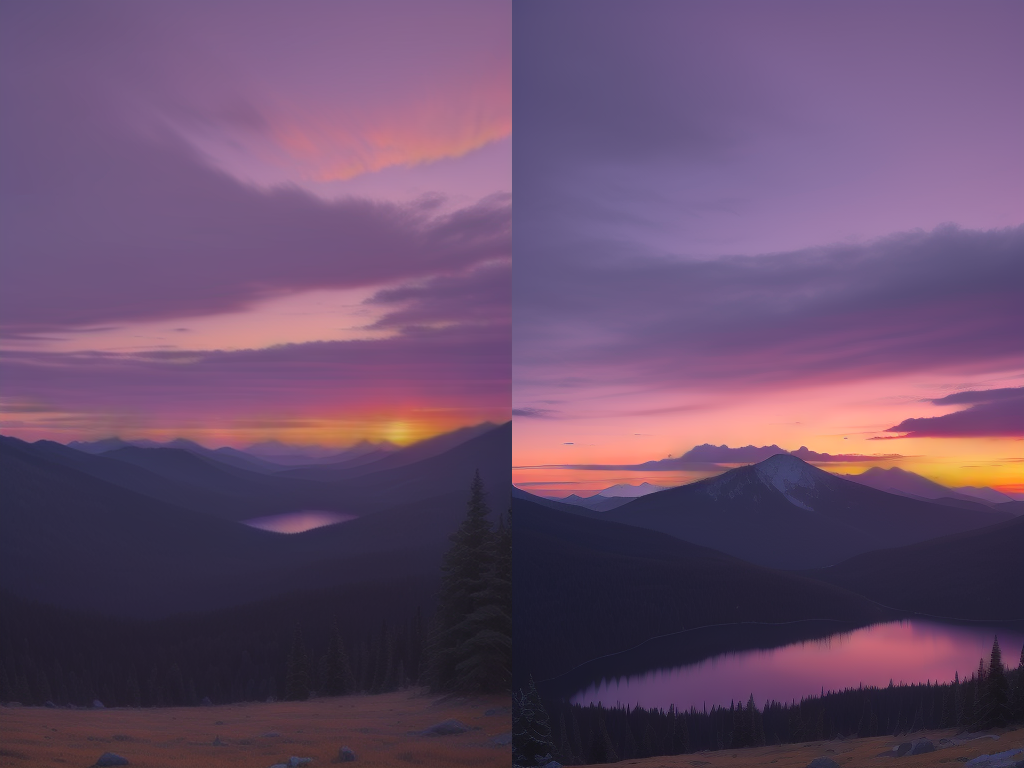

In [297]:
images = generator.generate(prompt="pine lake mountains in the distance, sunset, orange purple haze clouds", neg_bottleneck_scale=0.75, pos_bottleneck_scale=0.55, n_images=2,)
img = tile_images(images)
img

In [296]:
generator.liked = [images[0]]

In [282]:
#reset liked and disliked
generator.disliked = []
generator.liked = []
generator.round = 0

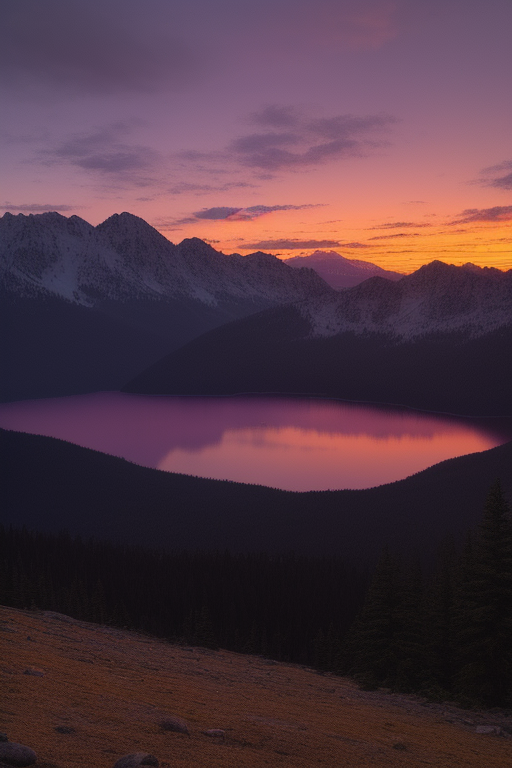

In [294]:
images[0]